In [1]:
import numpy as np
import cv2
import tifffile
from glob import glob
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import os
from os import listdir,makedirs
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
#Settings
# derive the training, validation, and testing directories
BASE_PATH_INPUT = "input/dataset_split_rgba_jpg/" 
TRAIN_PATH = os.path.sep.join([BASE_PATH_INPUT, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH_INPUT, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH_INPUT, "testing"])

img_size = 128
img_rows = img_size
img_cols = img_size

img_color = 'rgba'
#img_color = 'rgb'
#img_color = 'grayscale'
img_depth = 4
if img_color == 'rgb':
    img_depth = 3
elif img_color == 'grayscale':
    img_depth = 1

    

epochs = 1000
batch_size = 100
INIT_LR = 1e-3


BASE_PATH_OUTPUT = "output/OUT_05_fullaugment"
DATASET_TRAIN_PATH_OUTPUT = os.path.sep.join([BASE_PATH_OUTPUT, '/dataset/train/'])
DATASET_VAL_PATH_OUTPUT = os.path.sep.join([BASE_PATH_OUTPUT, '/dataset/validate/'])
DATASET_TEST_PATH_OUTPUT = os.path.sep.join([BASE_PATH_OUTPUT, '/dataset/test/'])
try:
    makedirs(BASE_PATH_OUTPUT)
except Exception as e:
    print ("Directory already exist, images will be written in same folder")
    
try:
    makedirs(DATASET_TRAIN_PATH_OUTPUT)
except Exception as e:
    print ("Directory already exist, images will be written in same folder")
    
try:
    makedirs(DATASET_VAL_PATH_OUTPUT)
except Exception as e:
    print ("Directory already exist, images will be written in same folder")
    
try:
    makedirs(DATASET_TEST_PATH_OUTPUT)
except Exception as e:
    print ("Directory already exist, images will be written in same folder")

In [3]:
%%capture cap --no-stderr
print("Settings:\n")
print("BASE_PATH_INPUT: ", BASE_PATH_INPUT)
print("BASE_PATH_OUTPUT: ", BASE_PATH_OUTPUT)
print("\n")
print("img_size: ", img_size)
print("img_rows: ", img_rows)
print("img_cols: ", img_cols)
print("img_color: ", img_color)
print("img_depth: ", img_depth)
print("\n")
print("EPOCHS: ", epochs)
print("BATCH_SIZE: ", batch_size)
print("INIT_LR: ", INIT_LR)


In [4]:
with open(BASE_PATH_OUTPUT + '/' + 'Settings.txt', 'w+') as f:
    f.write(cap.stdout)

In [5]:

# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    rescale=1 / img_size,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / img_size)

# initialize the training generator
trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    #save_to_dir=DATASET_TRAIN_PATH_OUTPUT,
    target_size=(img_rows, img_cols),
    color_mode=img_color,
    shuffle=True,
    batch_size=batch_size)

# initialize the validation generator
valGen = valAug.flow_from_directory(
    VAL_PATH,
    class_mode="categorical",
    #save_to_dir=DATASET_VAL_PATH_OUTPUT,
    target_size=(img_rows, img_cols),
    color_mode=img_color,
    shuffle=False,
    batch_size=batch_size)

# initialize the testing generator
testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    #save_to_dir=DATASET_TEST_PATH_OUTPUT,
    target_size=(img_rows, img_cols),
    color_mode=img_color,
    shuffle=False,
    batch_size=batch_size)

Found 4250 images belonging to 2 classes.
Found 472 images belonging to 2 classes.
Found 1181 images belonging to 2 classes.


In [6]:
#trainGen.next()
#valGen.next()
#testGen.next()

In [7]:
# Build model
model = Sequential()

model.add(Convolution2D(16, (5, 5), input_shape=(img_rows, img_cols, img_depth), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.1))

model.add(Convolution2D(16, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.1))

model.add(Convolution2D(32, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.1))

model.add(Convolution2D(64, (1, 1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(len(valGen.class_indices.keys())))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      1184      
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 40, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0

In [8]:
%%capture cap --no-stderr
model.summary()

In [9]:
with open(BASE_PATH_OUTPUT + '/' + 'model_summary.txt', 'w+') as f:
    f.write(cap.stdout)

In [10]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / epochs)
model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer=opt,
              metrics=['accuracy'])

In [11]:
#Train
history = model.fit(trainGen,
                    steps_per_epoch=trainGen.samples // batch_size,
                    epochs=epochs,
                    validation_data=valGen,
                    validation_steps=valGen.samples // batch_size)

Epoch 1/1000
42/42 [==============================] - 29s 701ms/step - loss: 0.6910 - accuracy: 0.5421 - val_loss: 0.6561 - val_accuracy: 0.6575
Epoch 2/1000
42/42 [==============================] - 21s 499ms/step - loss: 0.6357 - accuracy: 0.6427 - val_loss: 0.6436 - val_accuracy: 0.6100
Epoch 3/1000
42/42 [==============================] - 21s 494ms/step - loss: 0.6076 - accuracy: 0.6786 - val_loss: 0.6089 - val_accuracy: 0.6650
Epoch 4/1000
42/42 [==============================] - 21s 493ms/step - loss: 0.5932 - accuracy: 0.6969 - val_loss: 0.5846 - val_accuracy: 0.6875
Epoch 5/1000
42/42 [==============================] - 21s 492ms/step - loss: 0.5851 - accuracy: 0.7039 - val_loss: 0.5748 - val_accuracy: 0.7025
Epoch 6/1000
42/42 [==============================] - 21s 490ms/step - loss: 0.5830 - accuracy: 0.7000 - val_loss: 0.5754 - val_accuracy: 0.7000
Epoch 7/1000
42/42 [==============================] - 20s 487ms/step - loss: 0.5666 - accuracy: 0.7099 - val_loss: 0.5624 - val_ac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



42/42 [==============================] - 20s 485ms/step - loss: 0.4270 - accuracy: 0.8077 - val_loss: 0.4202 - val_accuracy: 0.8250
Epoch 237/1000
42/42 [==============================] - 20s 486ms/step - loss: 0.4335 - accuracy: 0.8106 - val_loss: 0.4184 - val_accuracy: 0.8150
Epoch 238/1000
42/42 [==============================] - 21s 492ms/step - loss: 0.4202 - accuracy: 0.8135 - val_loss: 0.4276 - val_accuracy: 0.7775
Epoch 239/1000
42/42 [==============================] - 20s 487ms/step - loss: 0.4183 - accuracy: 0.8075 - val_loss: 0.3954 - val_accuracy: 0.8175
Epoch 240/1000
42/42 [==============================] - 21s 494ms/step - loss: 0.4431 - accuracy: 0.8010 - val_loss: 0.4148 - val_accuracy: 0.8025
Epoch 241/1000
42/42 [==============================] - 20s 487ms/step - loss: 0.4172 - accuracy: 0.8183 - val_loss: 0.3898 - val_accuracy: 0.8250
Epoch 242/1000
42/42 [==============================] - 21s 490ms/step - loss: 0.4452 - accuracy: 0.7964 - val_loss: 0.4143 - val_acc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



42/42 [==============================] - 21s 490ms/step - loss: 0.4172 - accuracy: 0.8104 - val_loss: 0.4006 - val_accuracy: 0.8425
Epoch 308/1000
42/42 [==============================] - 20s 488ms/step - loss: 0.4238 - accuracy: 0.8142 - val_loss: 0.4011 - val_accuracy: 0.8475
Epoch 309/1000
42/42 [==============================] - 21s 490ms/step - loss: 0.4069 - accuracy: 0.8135 - val_loss: 0.3951 - val_accuracy: 0.8375
Epoch 310/1000
42/42 [==============================] - 21s 493ms/step - loss: 0.4245 - accuracy: 0.8176 - val_loss: 0.4068 - val_accuracy: 0.8225
Epoch 311/1000
42/42 [==============================] - 21s 488ms/step - loss: 0.4243 - accuracy: 0.8096 - val_loss: 0.4173 - val_accuracy: 0.8275
Epoch 312/1000
42/42 [==============================] - 20s 487ms/step - loss: 0.4032 - accuracy: 0.8186 - val_loss: 0.3949 - val_accuracy: 0.8175
Epoch 313/1000
42/42 [==============================] - 21s 491ms/step - loss: 0.4025 - accuracy: 0.8231 - val_loss: 0.3843 - val_acc

Epoch 366/1000
42/42 [==============================] - 21s 488ms/step - loss: 0.4301 - accuracy: 0.8082 - val_loss: 0.4095 - val_accuracy: 0.7975
Epoch 367/1000
42/42 [==============================] - 21s 493ms/step - loss: 0.3995 - accuracy: 0.8229 - val_loss: 0.3963 - val_accuracy: 0.8375
Epoch 368/1000
42/42 [==============================] - 20s 483ms/step - loss: 0.4225 - accuracy: 0.8145 - val_loss: 0.4049 - val_accuracy: 0.8250
Epoch 369/1000
42/42 [==============================] - 20s 486ms/step - loss: 0.4115 - accuracy: 0.8176 - val_loss: 0.4149 - val_accuracy: 0.8100
Epoch 370/1000
42/42 [==============================] - 20s 487ms/step - loss: 0.4104 - accuracy: 0.8214 - val_loss: 0.4024 - val_accuracy: 0.8325
Epoch 371/1000
42/42 [==============================] - 20s 487ms/step - loss: 0.4133 - accuracy: 0.8113 - val_loss: 0.3947 - val_accuracy: 0.8350
Epoch 372/1000
42/42 [==============================] - 21s 489ms/step - loss: 0.4072 - accuracy: 0.8181 - val_loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



42/42 [==============================] - 21s 493ms/step - loss: 0.4020 - accuracy: 0.8243 - val_loss: 0.3609 - val_accuracy: 0.8725
Epoch 766/1000
42/42 [==============================] - 20s 488ms/step - loss: 0.3993 - accuracy: 0.8289 - val_loss: 0.3719 - val_accuracy: 0.8425
Epoch 767/1000
42/42 [==============================] - 21s 497ms/step - loss: 0.3954 - accuracy: 0.8318 - val_loss: 0.3770 - val_accuracy: 0.8325
Epoch 768/1000
42/42 [==============================] - 21s 504ms/step - loss: 0.3925 - accuracy: 0.8265 - val_loss: 0.3759 - val_accuracy: 0.8425
Epoch 769/1000
42/42 [==============================] - 21s 493ms/step - loss: 0.3955 - accuracy: 0.8335 - val_loss: 0.3744 - val_accuracy: 0.8250
Epoch 770/1000
42/42 [==============================] - 21s 490ms/step - loss: 0.3939 - accuracy: 0.8311 - val_loss: 0.3694 - val_accuracy: 0.8575
Epoch 771/1000
42/42 [==============================] - 20s 487ms/step - loss: 0.3929 - accuracy: 0.8296 - val_loss: 0.3701 - val_acc

Epoch 821/1000
42/42 [==============================] - 20s 484ms/step - loss: 0.3959 - accuracy: 0.8217 - val_loss: 0.3768 - val_accuracy: 0.8550
Epoch 822/1000
42/42 [==============================] - 20s 484ms/step - loss: 0.3976 - accuracy: 0.8267 - val_loss: 0.3890 - val_accuracy: 0.8300
Epoch 823/1000
42/42 [==============================] - 21s 490ms/step - loss: 0.4037 - accuracy: 0.8205 - val_loss: 0.3915 - val_accuracy: 0.8400
Epoch 824/1000
42/42 [==============================] - 20s 488ms/step - loss: 0.3865 - accuracy: 0.8280 - val_loss: 0.3745 - val_accuracy: 0.8550
Epoch 825/1000
42/42 [==============================] - 20s 487ms/step - loss: 0.3997 - accuracy: 0.8282 - val_loss: 0.3752 - val_accuracy: 0.8375
Epoch 826/1000
42/42 [==============================] - 21s 489ms/step - loss: 0.3918 - accuracy: 0.8347 - val_loss: 0.3794 - val_accuracy: 0.8600
Epoch 827/1000
42/42 [==============================] - 20s 485ms/step - loss: 0.3923 - accuracy: 0.8265 - val_loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



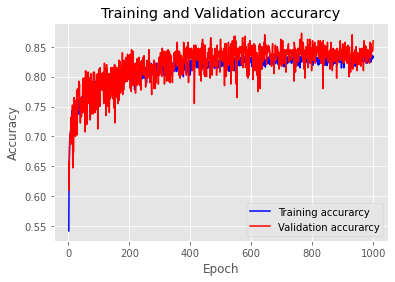

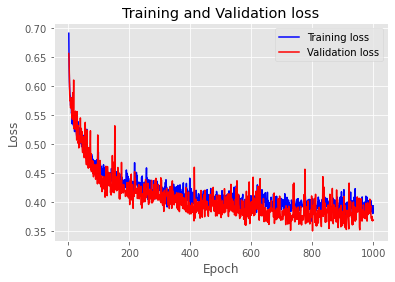

In [12]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.figure()
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(BASE_PATH_OUTPUT + '/' + 'Training and validation accuracy.png')

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(BASE_PATH_OUTPUT + '/' + 'Training and validation loss.png')
plt.show()

In [13]:
#Confution Matrix and Classification Report of validation data
valGen.reset() # resetting generator
y_pred_val = model.predict_generator(valGen, valGen.samples // batch_size+1, verbose = True)
y_pred_val = np.argmax(y_pred_val, axis=1)
print('Confusion Matrix of validation data')
print(confusion_matrix(valGen.classes, y_pred_val))
print('Classification Report of validation data')
print(classification_report(valGen.classes, y_pred_val, target_names=list(valGen.class_indices.keys())  ))

Instructions for updating:
Please use Model.predict, which supports generators.
5/5 [==============================] - 0s 66ms/step
Confusion Matrix of validation data
[[178  35]
 [ 25 234]]
Classification Report of validation data
              precision    recall  f1-score   support

     Field_1       0.88      0.84      0.86       213
     Field_4       0.87      0.90      0.89       259

    accuracy                           0.87       472
   macro avg       0.87      0.87      0.87       472
weighted avg       0.87      0.87      0.87       472



In [14]:
%%capture cap --no-stderr
print('Confusion Matrix of validation data')
print(confusion_matrix(valGen.classes, y_pred_val))
print('\n\nClassification Report of validation data')
print(classification_report(valGen.classes, y_pred_val, target_names=list(valGen.class_indices.keys())  ))

In [15]:
with open(BASE_PATH_OUTPUT + '/' + 'report_validation.txt', 'w') as f:
    f.write(cap.stdout)

In [16]:
#Confution Matrix and Classification Report of test data
testGen.reset() # resetting generator
y_pred_test = model.predict_generator(testGen, testGen.samples // batch_size+1, verbose = True)
y_pred_test = np.argmax(y_pred_test, axis=1)
print('Confusion Matrix of test data')
print(confusion_matrix(testGen.classes, y_pred_test))
print('Classification Report of test data')
print(classification_report(testGen.classes, y_pred_test, target_names=list(testGen.class_indices.keys())  ))

12/12 [==============================] - 2s 130ms/step
Confusion Matrix of test data
[[476 108]
 [ 69 528]]
Classification Report of test data
              precision    recall  f1-score   support

     Field_1       0.87      0.82      0.84       584
     Field_4       0.83      0.88      0.86       597

    accuracy                           0.85      1181
   macro avg       0.85      0.85      0.85      1181
weighted avg       0.85      0.85      0.85      1181



In [17]:
%%capture cap --no-stderr
print('Confusion Matrix of test data')
print(confusion_matrix(testGen.classes, y_pred_test))
print('\n\nClassification Report of test data')
print(classification_report(testGen.classes, y_pred_test, target_names=list(testGen.class_indices.keys())  ))

In [18]:
with open(BASE_PATH_OUTPUT + '/' + 'report_test.txt', 'w') as f:
    f.write(cap.stdout)

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

def multiclass_roc_auc_score(_y_test, _y_pred, savedir=BASE_PATH_OUTPUT, savename='multiclass_roc_auc_score', _average="macro"):
    lb = LabelBinarizer()
    lb.fit(_y_test)
    _y_test = lb.transform(_y_test)
    _y_pred = lb.transform(_y_pred)

    plt.figure()
    for (idx, c_label) in enumerate(valGen.class_indices.keys()): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(_y_test[:,idx].astype(int), _y_pred[:,idx])
        plt.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    plt.plot(fpr, tpr, 'b-', label = 'Random Guessing')
    
    plt.title('multiclass_roc_auc_score')
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend()
    plt.savefig(savedir + '/' + savename + '.png')
    return roc_auc_score(_y_test, _y_pred, average=_average)

# calling
multiclass_roc_auc_score(valGen.classes, y_pred_val, savename='multiclass_roc_auc_score_validation')
multiclass_roc_auc_score(testGen.classes, y_pred_test, savename='multiclass_roc_auc_score_test')

In [19]:
model.save(BASE_PATH_OUTPUT + '/' + "model.h5")